In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import torch
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from pytorch_lightning.loggers import TensorBoardLogger
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
from systems.Fields.scalar_field import Scalar_Field
from systems.Fields.phi4 import Phi4
from flows.NormalizingFlow import NormalizingFlow    
from lattice import Lattice
torch.set_default_dtype(torch.float64)

def set_random_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

set_random_seed(42)


L = 8
latt = Lattice([16,L],[16,4],device=device)
sf = Scalar_Field(latt,1)
sf.set_J_local(1,[0,L//2])





In [4]:
normal_dist = latt.normal_sampler()
train_loader = latt.get_train_loader(epoch_size = 2**16,batch_size=2 ** 10)

In [5]:
class Pipeline(pl.LightningModule):
    def __init__(
        self,
        model,
        latent,
        criterion,
        optimizer_class=torch.optim.Adam,
        optimizer_kwargs={"lr": 0.001,"weight_decay": 0}
    ) -> None:
        
        super().__init__()
        self.model = model

        self.loss = criterion.to(device)
        self.latent = latent
        self.optimizer_class = optimizer_class
        self.optimizer_kwargs = optimizer_kwargs
        
    """
    def configure_optimizers(self):
        optimizer = self.optimizer_class(
            self.model.parameters(), **self.optimizer_kwargs
        )
        return optimizer
    """
    
    def configure_optimizers(self):
        optimizer = self.optimizer_class(self.model.parameters(), **self.optimizer_kwargs)
        
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer=optimizer,
            min_lr=1e-5,
            factor=0.99,
            mode="min",
            patience = 2
        )

        lr_scheduler = {
            "scheduler": scheduler,
            "interval": "epoch",
            "monitor": "train_loss",
        }
        return [optimizer], [lr_scheduler]

    def training_step(self, batch, batch_idx):
        z = batch.to(device)
        latent_log_prob = torch.sum(self.latent.log_prob(z.cpu()).to(device),-1)
        x, log_abs_det = self.model.g(z)
        loss = self.loss(x,log_abs_det)
        ess = self.loss.ESS(latent_log_prob,log_abs_det)

        
        sch = self.lr_schedulers()
        sch.step(loss)
        self.log('train_loss', loss,prog_bar=True)
        self.log('ess',ess)
        self.log('mean_x',torch.mean(x))
        self.log('lr',sch.get_last_lr()[0])
        return loss


    def on_train_epoch_end(self):
        #print("---------------------------end epoch---------------------------------")
        pass
    
    def on_validation_end(self) -> None:
        if not self.automatic_optimization:
            # Save a checkpoint of the model
            ckpt_path = os.path.join(self.trainer.log_dir, 'checkpoints', 'ckpt.pt')
            self.trainer.save_checkpoint(ckpt_path, weights_only=True)
        return super().on_validation_end()
    
    

In [ ]:
set_random_seed(42)
nf = NormalizingFlow.config_and_init(n_flows = 4,num_hidden = 6,hidden_dim = 2 * latt.total_nodes,lattice=latt,ort=True)
nf.save("./weights/field.pth") 

In [ ]:
nf = NormalizingFlow.load_model("./weights/field.pth").to(device)

In [17]:
z = next(iter(train_loader)).to(device)
print(z.device)
x, _ = nf.g(z)

cuda:0


In [22]:
set_random_seed(42)


pipeline = Pipeline(model = nf, 
                  latent = normal_dist ,
                  criterion = sf.get_KL(), 
                  optimizer_class=torch.optim.Adam,
                  optimizer_kwargs={"lr": 0.001,"weight_decay":0.0}).to(device)

trainer = pl.Trainer(
        max_epochs = 2,
        logger = TensorBoardLogger(save_dir=f"./logs/field"),
        num_sanity_val_steps = 0,
        log_every_n_steps = 1,
        enable_checkpointing = False,
        accumulate_grad_batches = 1)

trainer.fit(model=pipeline, train_dataloaders = train_loader)
nf.save("./weights/field.pth")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type            | Params | Mode 
--------------------------------------------------
0 | model | NormalizingFlow | 5.4 M  | train
1 | loss  | KL_with_S       | 0      | train
--------------------------------------------------
5.4 M     Trainable params
0         Non-trainable params
5.4 M     Total params
21.473    Total estimated model params size (MB)
351       Modules in train mode
0         Modules in eval mode


Epoch 1: 100%|██████████| 64/64 [00:12<00:00,  5.14it/s, v_num=26, train_loss=-64.9] 

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 64/64 [00:12<00:00,  5.14it/s, v_num=26, train_loss=-64.9]


In [21]:
nf = NormalizingFlow.load_model("./weights/field.pth").to(device)

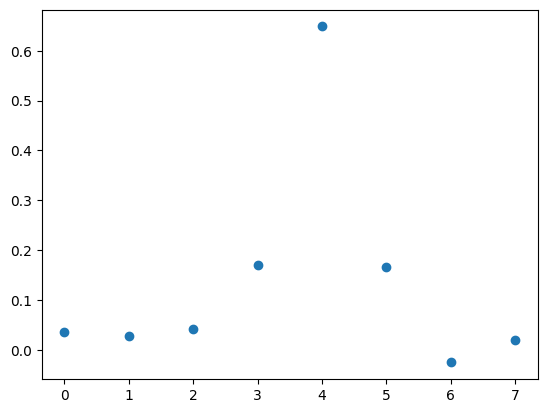

In [20]:
z = normal_dist.sample((100,)).to(device)
with torch.no_grad():
    phi, _ = nf.g(z)
phi = torch.mean(phi,0)

av = sf.lattice.get_time_averaging_mat()
phi = torch.matmul(av,phi)

plt.figure()
plt.scatter(np.arange(sf.lattice.n_nodes[1]),-phi.cpu())
plt.show()